# Investigator

This notebook is supposed to be an interactive tool to look at parameters and values hidden in the network states. By default you can look at model checkpoints and visualize the different weights

Investigator additionally is capable to read saved model-output (.pkl) files to investigate different parameters and explore plotting and animation of time related properties

In [1]:
#           ."""-.
#          /      \
#          |  _..--'-.
#          >.`__.-"";"`
#         / /(     ^\
#         '-`)     =|-.
#          /`--.'--'   \ .-.
#        .'`-._ `.\    | J /
#       /      `--.|   \__/
#
#
#
# Copyright 2019 Markus Ernst
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.


# standard libraries
# -----
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
from tensorflow.python.training import checkpoint_utils as cu
# TODO: Incorporate TSNE library here

# custom functions
# -----
import visualizer

W1024 12:27:02.004558 139966945564416 deprecation_wrapper.py:119] From /home/mernst/.local/lib/python3.5/site-packages/tfplot/figure.py:18: The name tf.Summary is deprecated. Please use tf.compat.v1.Summary instead.



In [2]:
# interactive mode /eager execution
tf.enable_eager_execution()

In [3]:
def get_list_of_images(list_of_weights, stereo):


    for kernel in list_of_weights:
        kernel_name = kernel[0]
        kernel_value = kernel[1]
        kname = kernel_name.split('/')[1].split('_')[0] + '/kernels'
        receptive_pixels = kernel_value.shape[0].value
        if 'fc' in kname:
            pass
        elif 'conv0' in kname:
            if stereo:
                image.append(
                    tf.compat.v1.summary.image(kname, put_kernels_on_grid(
                        kname, tf.reshape(kernel_value,
                                          [2 * receptive_pixels,
                                              receptive_pixels, -1,
                                              network.
                                              net_params
                                              ['conv_filter_shapes'][0][-1]])),
                                     max_outputs=1))
            else:
                image.append(
                    tf.compat.v1.summary.image(kname, put_kernels_on_grid(
                        kname, kernel_value),
                        max_outputs=1))

        else:
            image.append(
                tf.compat.v1.summary.image(kname, put_kernels_on_grid(
                    kname, tf.reshape(
                        kernel_value, [receptive_pixels, receptive_pixels,
                                 1, -1])), max_outputs=1))

    return image


In [4]:
def get_model_paths():
    pass

In [5]:
def configure_widgets():
    toggle = widgets.ToggleButtons(
        options=['0 (B)', '1 (B-F)', '2 (B-K)','3 (BT)', '4 (BL)', '5 (BLT)'],
        description='Architecture:',
        disabled=False,
        button_style='', # 'success', 'info', 'warning', 'danger' or ''
        tooltips=['Description of slow', 'Description of regular', 'Description of fast'],
    #     icons=['check'] * 3
    )

    slider = widgets.IntSlider(min=0,
        max=3,
        step=1,
        description='Timestep:',
        value=3)

    dropdown = widgets.Dropdown(
        options=['1', '2', '3'],
        value='2',
        description='Variable:',
        disabled=False,
    )

    irange = widgets.IntRangeSlider(
        value=[0, 10000],
        min=0,
        max=10000,
        step=100,
        description='Test:',
        disabled=False,
        continuous_update=False,
        orientation='horizontal',
        readout=True,
        readout_format='d',
    )

    play = widgets.Play(
    #     interval=10,
        value=irange.value[0],
        min=0,
        max=10000,
        step=100,
        description="Press play",
        disabled=False
    )
    playslide = widgets.IntSlider(
        min=0,
        max=10000)

    widgets.jslink((irange, 'min'), (playslide, 'value'))
    widgets.jslink((play, 'value'), (playslide, 'value'))


    playwidget = widgets.HBox([play, playslide])

    accordion = widgets.Accordion(children=[toggle, slider, dropdown, irange, playwidget])
    accordion.set_title(0, 'Choose Configuration')
    accordion.set_title(1, 'Timestep')
    accordion.set_title(2, 'Look at')
    accordion.set_title(3, 'Iterationrange')
    accordion.set_title(4, 'Animate')

    return accordion

In [6]:
configure_widgets()

Accordion(children=(ToggleButtons(description='Architecture:', options=('0 (B)', '1 (B-F)', '2 (B-K)', '3 (BT)…

In [7]:
modelpath = '/Users/markus/Research/Code/saturn/experiments/001_noname_experiment/data/config0/B0_2l_fm1_d1.0_l20.0_bn1_bs100_lr0.003/mnist_2occ_Xp/28x28x1_grayscale_onehot/checkpoints/'
#modelpath = '/home/aecgroup/aecdata/Results_python/markus/experiments/010_osfashionmnist_stereo/data/config5/i1/BLT3_2l_fm1_d1.0_l20.0_bn1_bs500_lr0.003/osfashionmnist_2occ_Xp/32x32x2_grayscale_onehot/checkpoints/'


list_of_variables = cu.list_variables(modelpath)
#get_list_of_images(list_of_variables, False)

conv0weights = cu.load_variable(modelpath, 'convolutional_layer_0/conv0_conv_var')
conv0weights = tf.convert_to_tensor(conv0weights)
viz = visualizer.put_kernels_on_grid(name='conv0_weights', kernel=conv0weights)
viz_np = viz.numpy()    
plt.imshow(viz_np[0,:,:,0], cmap='gray')
plt.show()

conv0weights = cu.load_variable(modelpath, 'convolutional_layer_0/conv0_conv_var')
conv0weights = tf.convert_to_tensor(conv0weights)
viz = visualizer.put_kernels_on_grid(name='conv0_weights', kernel=conv0weights)
viz_np = viz.numpy()    
plt.imshow(viz_np[0,:,:,0], cmap='gray')
plt.show()

conv0weights = cu.load_variable(modelpath, 'convolutional_layer_0/conv0_conv_var')
conv0weights = tf.convert_to_tensor(conv0weights)
viz = visualizer.put_kernels_on_grid(name='conv0_weights', kernel=conv0weights)
viz_np = viz.numpy()    
plt.imshow(viz_np[0,:,:,0], cmap='gray')
plt.show()

conv0weights = cu.load_variable(modelpath, 'convolutional_layer_0/conv0_conv_var')
conv0weights = tf.convert_to_tensor(conv0weights)
viz = visualizer.put_kernels_on_grid(name='conv0_weights', kernel=conv0weights)
viz_np = viz.numpy()    
plt.imshow(viz_np[0,:,:,0], cmap='gray')
plt.show()

conv0weights = cu.load_variable(modelpath, 'convolutional_layer_0/conv0_conv_var')
conv0weights = tf.convert_to_tensor(conv0weights)
viz = visualizer.put_kernels_on_grid(name='conv0_weights', kernel=conv0weights)
viz_np = viz.numpy()    
plt.imshow(viz_np[0,:,:,0], cmap='gray')
plt.show()

InvalidArgumentError: Unsuccessful TensorSliceReader constructor: Failed to get matching files on /Users/markus/Research/Code/saturn/experiments/001_noname_experiment/data/config0/B0_2l_fm1_d1.0_l20.0_bn1_bs100_lr0.003/mnist_2occ_Xp/28x28x1_grayscale_onehot/checkpoints/: Not found: /Users/markus/Research/Code/saturn/experiments/001_noname_experiment/data/config0/B0_2l_fm1_d1.0_l20.0_bn1_bs100_lr0.003/mnist_2occ_Xp/28x28x1_grayscale_onehot/checkpoints; No such file or directory

[Visualization] conv0_weights grid: 32 = (4, 8)


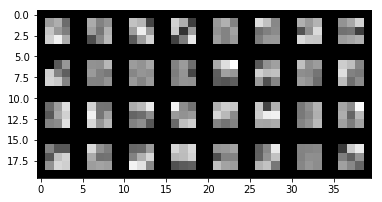

In [32]:
modelpath = '/Users/markus/Research/Code/saturn/experiments/001_noname_experiment/data/config0/B0_2l_fm1_d1.0_l20.0_bn1_bs100_lr0.003/mnist_2occ_Xp/28x28x1_grayscale_onehot/checkpoints/'
#modelpath = '/home/aecgroup/aecdata/Results_python/markus/experiments/009_osmnist_stereo/data/config5/i1/BLT3_2l_fm1_d1.0_l20.0_bn1_bs500_lr0.003/osmnist_2occ_Xp/32x32x2_grayscale_onehot/checkpoints/'


list_of_variables = cu.list_variables(modelpath)
#get_list_of_images(list_of_variables, False)

conv0weights = cu.load_variable(modelpath, 'convolutional_layer_0/conv0_conv_var')
conv0weights = tf.convert_to_tensor(conv0weights)
viz = visualizer.put_kernels_on_grid(name='conv0_weights', kernel=conv0weights)
viz_np = viz.numpy()    
plt.imshow(viz_np[0,:,:,0], cmap='gray')
plt.show()